# 17-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기
이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

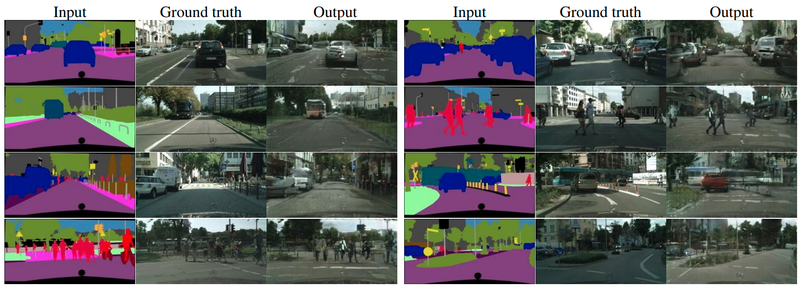

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있습니다.
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

[cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해 봅시다.
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

- [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

프로젝트를 수행하기 전에 주요 라이브러리 버전을 살펴 봅시다.

In [1]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


### 프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 **augmentation 방법을 적용**하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)

  - (사용된 방법: 1-4 부분 참고) 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용
    1. 두 이미지를 채널 축으로 연결(tf.concat)
    2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용 (tf.pad)
    3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냄 (tf.image.random_crop)
    4. 3.의 결과를 50% 확률로 가로로 뒤집기 (tf.image.random_flip_left_right)
    5. 4.의 결과를 50% 확률로 세로로 뒤집기 (tf.image.random_flip_up_down)
    6. 5.의 결과를 50% 확률로 회전 (tf.image.rot90) <br> <br>
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator를 사용**해 주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 **중간 손실 값에 대한 로그**를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


# ※ 프로젝트 수행 시작

## 1. 데이터 준비 및 전처리

### 1-1. 데이터 준비 및 개수 확인

- 아래 명령어로 데이터 준비
  - \$ cd ~/aiffel/conditional_generation/data && unzip cityscapes.zip

In [2]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


- 학습용 데이터: 1,000개 이미지

In [3]:
data_path2 = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'
print("number of train examples :", len(os.listdir(data_path2)))

number of train examples : 5


- 테스트 데이터: 5개 이미지

### 1-2. 데이터 시각화 및 이미지 크기 확인
- 각각의 이미지 확인: 학습용 데이터셋에서 임의로 6장 선택 시각화

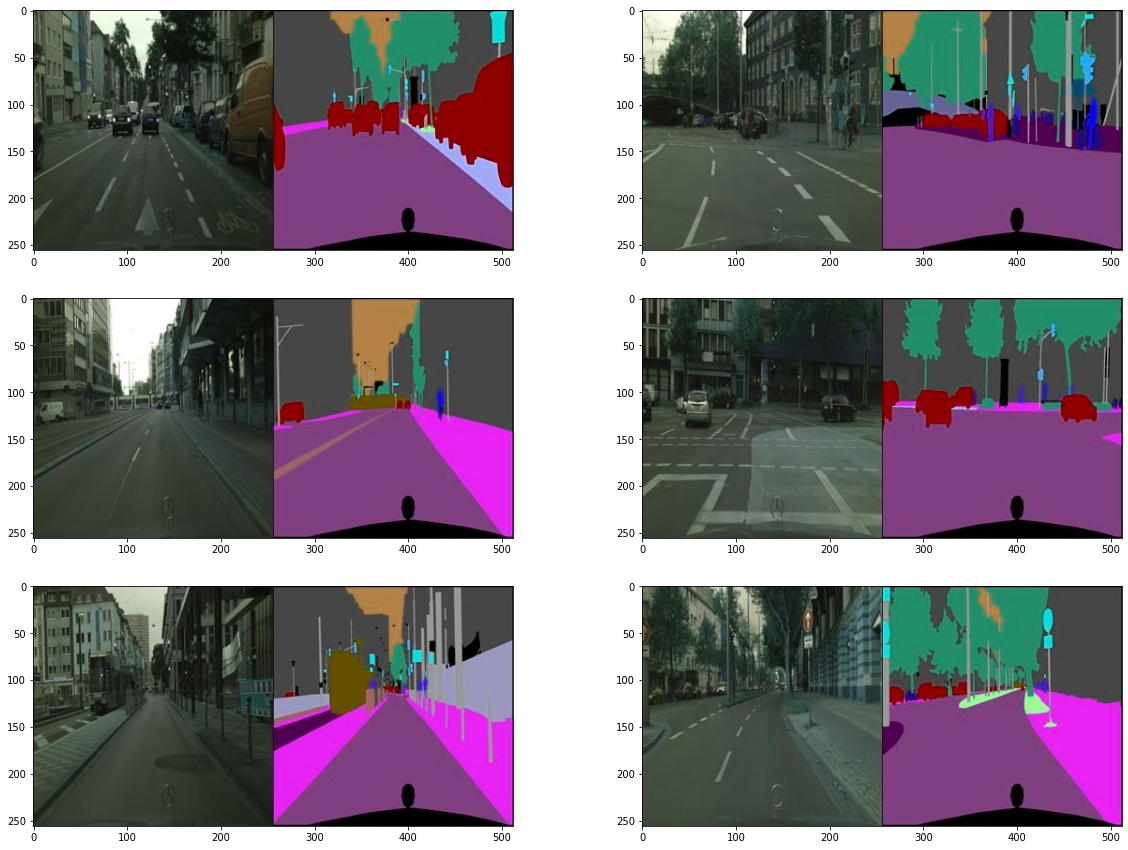

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 하나의 이미지에 도로의 실제 이미지와 스케치 이미지가 함께 포함되어 있음
<br> <br>
#### [이미지 크기 확인]

In [5]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 이미지 크기: (256, 512, 3)
- (256, 256, 3) 크기 이미지를 2개 이미지로 분할하여 학습에 사용

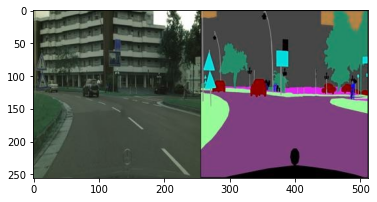

In [6]:
plt.imshow(img)

### 1-3. 이미지 분할

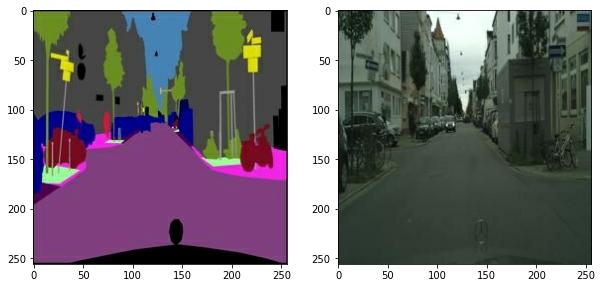

In [7]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    #sketch = img[:, :w, :] 
    #sketch = tf.cast(sketch, tf.float32)
    #colored = img[:, w:, :] 
    #colored = tf.cast(colored, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### 1-4. 데이터 Augmentation
- 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법 적용

In [8]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


- apply_augmentation 함수
  - 스케치 이미지와 채색된 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용  

#### [사용된 방법]
1. 두 이미지를 채널 축으로 연결(tf.concat): 두 이미지가 각각 3채널인 경우 6채널이 됨
2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용 (tf.pad)
3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냄 (tf.image.random_crop)
4. 3.의 결과를 50% 확률로 가로로 뒤집기 (tf.image.random_flip_left_right)
5. 4.의 결과를 50% 확률로 세로로 뒤집기 (tf.image.random_flip_up_down)
6. 5.의 결과를 50% 확률로 회전 (tf.image.rot90)

#### [적용 결과 확인 - 시각화]

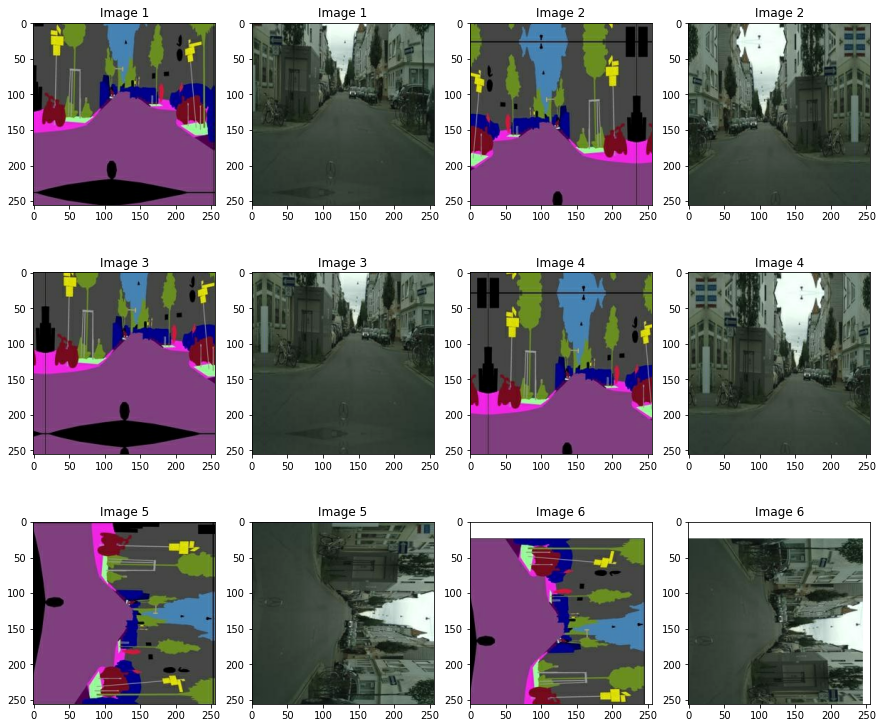

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- **적용된 결과 검토** (확률적으로 변형을 시도하므로 실행할 때마다 결과가 다름)
  - Image 1: 그림이 위로 옮겨짐 (tf.pad)
  - Image 2: 가로로 뒤집기 적용됨 (tf.image.random_flip_left_right)
  - Image 3: 가로로 뒤집기 (tf.image.random_flip_left_right) + 90도 회전 적용됨 (tf.image.rot90)
  - Image 4: 세로로 뒤집기 적용됨 (tf.image.random_flip_up_down)
  - Image 5: 90도 회전 적용됨 (tf.image.rot90)
  - Image 6: 가로로 뒤집기 (tf.image.random_flip_left_right) + 90도 회전 적용됨 (tf.image.rot90)  

#### [전체 적용]
- 학습 데이터 전체에 Augmentation 적용 및 결과 확인 (하나의 이미지만 시각화)

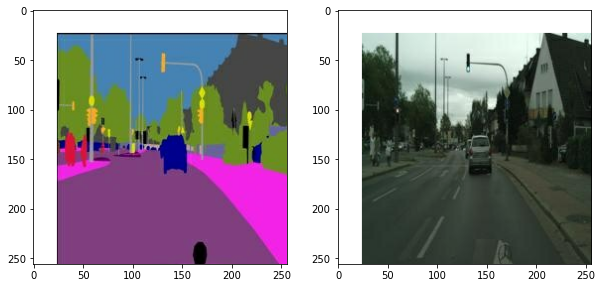

In [10]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2. Pix2Pix Generator 구성
- Tensorflow의 Subclassing 방법 이용

### 2-1. Encode Block 구현
  - "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 구현

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


### 2-2. Encoder 구현

In [12]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


### 2-3. Encoder 모델 확인
- 레이어가 제대로 구성되었는지 확인
  - Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 확인

In [13]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

### 2-4. Decode Block 및 Decoder 구현

In [14]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


- 처음 세 개의 블록에서만 Dropout 사용
- 마지막 convolution에는 3개의 필터를 사용해 출력

### 2-5. Decoder 모델 확인
- 레이어가 제대로 구성되었는지 확인
  - Decoder에 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인

In [15]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

- (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 출력

### 2-6. Plain Generator 구현
- Encoder와 Decoder를 연결
  - Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환
  - Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있음
  - 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력

In [16]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


- Generator: 약 4000만 개의 파라미터(Trainable params: 39,076,480)

###  2-7. U-Net Generator 구현
- 이전 단계에서 구현했던 Plain Generator를 수정하여 U-Net 구조 구현
  - \_\_init\_\_() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록 정의
  - call()에서 forward propagation
    - skip connection 구현

In [17]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


### 2-8. U-Net Generator 모델 확인

In [18]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

- Skip connection을 추가한 U-Net Generator의 파라미터 약 5,500만 개
  - Plain Generator 파라미터는 약 4,000만 개

## 3. Pix2Pix Discriminator 구현

### 3-1. Discriminator Block구현

In [19]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


### 3-2. Discriminator 구현

In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


- 첫 번째 블록은 단순한 연결(concat) 수행
- Discriminator의 최종 출력은 sigmoid 활성화 사용

### 3-3. Discriminator 모델 확인

In [21]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

- 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력 시각화해

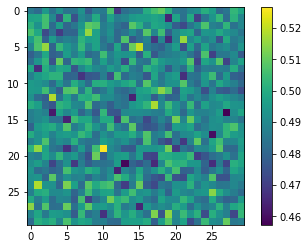

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 4. 모델 학습

### 4-1. 손실함수 구현
- 두 가지 손실 함수(L1 손실함수, cGAN 손실함수) 모두 사용

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


### 4-2. Optimizer 구현

In [24]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


### 4-3. Train Step 구현
- 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정 구현

In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


- gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100(=λ)을 곱함
  - λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100을 사용

### 4-4. 학습 실행

In [26]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8811                     
L1_loss:0.3369                     
Discriminator_loss:1.2957

EPOCH[1] - STEP[20]                     
Generator_loss:0.8892                     
L1_loss:0.2744                     
Discriminator_loss:1.2929

EPOCH[1] - STEP[30]                     
Generator_loss:0.9040                     
L1_loss:0.1956                     
Discriminator_loss:1.3171

EPOCH[1] - STEP[40]                     
Generator_loss:0.9249                     
L1_loss:0.2015                     
Discriminator_loss:1.3134

EPOCH[1] - STEP[50]                     
Generator_loss:0.8108                     
L1_loss:0.2047                     
Discriminator_loss:1.3741

EPOCH[1] - STEP[60]                     
Generator_loss:0.9607                     
L1_loss:0.1984                     
Discriminator_loss:1.3929

EPOCH[1] - STEP[70]                     
Generator_loss:1.0074                     
L1_loss:0.1416                    

EPOCH[3] - STEP[70]                     
Generator_loss:0.9942                     
L1_loss:0.1853                     
Discriminator_loss:1.3888

EPOCH[3] - STEP[80]                     
Generator_loss:1.8262                     
L1_loss:0.1926                     
Discriminator_loss:0.3373

EPOCH[3] - STEP[90]                     
Generator_loss:2.1579                     
L1_loss:0.1783                     
Discriminator_loss:1.6195

EPOCH[3] - STEP[100]                     
Generator_loss:2.4447                     
L1_loss:0.1773                     
Discriminator_loss:0.6995

EPOCH[3] - STEP[110]                     
Generator_loss:0.9818                     
L1_loss:0.1773                     
Discriminator_loss:0.8270

EPOCH[3] - STEP[120]                     
Generator_loss:0.9604                     
L1_loss:0.2059                     
Discriminator_loss:0.7814

EPOCH[3] - STEP[130]                     
Generator_loss:1.9677                     
L1_loss:0.1828                

EPOCH[5] - STEP[130]                     
Generator_loss:1.9844                     
L1_loss:0.2170                     
Discriminator_loss:0.3633

EPOCH[5] - STEP[140]                     
Generator_loss:1.3562                     
L1_loss:0.1864                     
Discriminator_loss:0.5028

EPOCH[5] - STEP[150]                     
Generator_loss:3.1874                     
L1_loss:0.2072                     
Discriminator_loss:1.2537

EPOCH[5] - STEP[160]                     
Generator_loss:0.4386                     
L1_loss:0.2088                     
Discriminator_loss:1.4186

EPOCH[5] - STEP[170]                     
Generator_loss:0.3938                     
L1_loss:0.1892                     
Discriminator_loss:1.5663

EPOCH[5] - STEP[180]                     
Generator_loss:1.8912                     
L1_loss:0.1701                     
Discriminator_loss:0.5774

EPOCH[5] - STEP[190]                     
Generator_loss:0.7090                     
L1_loss:0.1906             

EPOCH[7] - STEP[190]                     
Generator_loss:1.5106                     
L1_loss:0.1786                     
Discriminator_loss:0.7936

EPOCH[7] - STEP[200]                     
Generator_loss:1.6925                     
L1_loss:0.1695                     
Discriminator_loss:0.8456

EPOCH[7] - STEP[210]                     
Generator_loss:2.3233                     
L1_loss:0.2302                     
Discriminator_loss:0.1770

EPOCH[7] - STEP[220]                     
Generator_loss:1.6536                     
L1_loss:0.1703                     
Discriminator_loss:0.6378

EPOCH[7] - STEP[230]                     
Generator_loss:1.5325                     
L1_loss:0.1944                     
Discriminator_loss:0.5298

EPOCH[7] - STEP[240]                     
Generator_loss:0.9048                     
L1_loss:0.1563                     
Discriminator_loss:1.5456

EPOCH[7] - STEP[250]                     
Generator_loss:1.9469                     
L1_loss:0.2018             

EPOCH[9] - STEP[250]                     
Generator_loss:0.9030                     
L1_loss:0.1788                     
Discriminator_loss:1.6739

EPOCH[10] - STEP[10]                     
Generator_loss:1.0945                     
L1_loss:0.1585                     
Discriminator_loss:0.8565

EPOCH[10] - STEP[20]                     
Generator_loss:0.9163                     
L1_loss:0.1611                     
Discriminator_loss:0.9176

EPOCH[10] - STEP[30]                     
Generator_loss:2.2891                     
L1_loss:0.1511                     
Discriminator_loss:1.1266

EPOCH[10] - STEP[40]                     
Generator_loss:1.3285                     
L1_loss:0.1761                     
Discriminator_loss:0.6903

EPOCH[10] - STEP[50]                     
Generator_loss:2.4920                     
L1_loss:0.2155                     
Discriminator_loss:0.1683

EPOCH[10] - STEP[60]                     
Generator_loss:1.7784                     
L1_loss:0.1835             

## 5. 모델 테스트

/aiffel/aiffel/conditional_generation/data/cityscapes/val/1.jpg
/aiffel/aiffel/conditional_generation/data/cityscapes/val/5.jpg
/aiffel/aiffel/conditional_generation/data/cityscapes/val/2.jpg
/aiffel/aiffel/conditional_generation/data/cityscapes/val/3.jpg
/aiffel/aiffel/conditional_generation/data/cityscapes/val/4.jpg


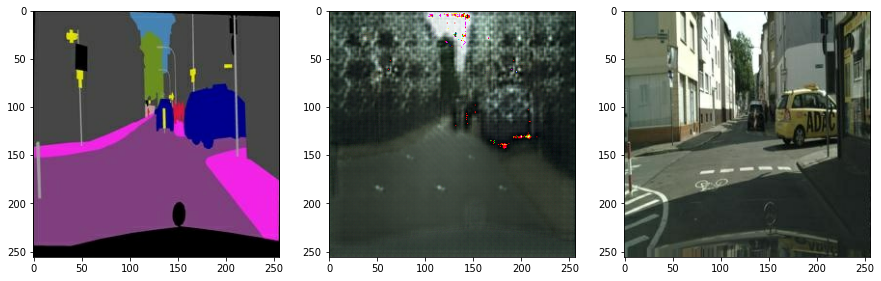

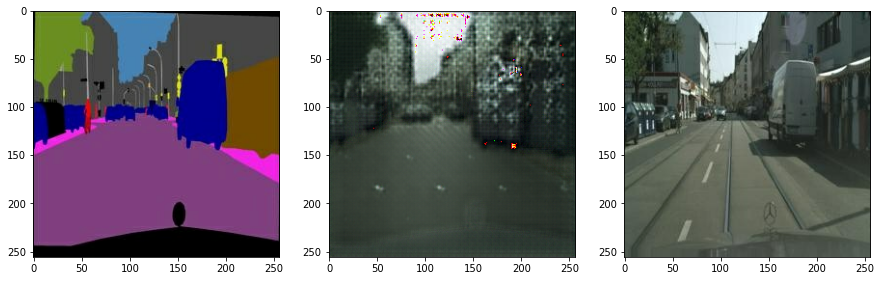

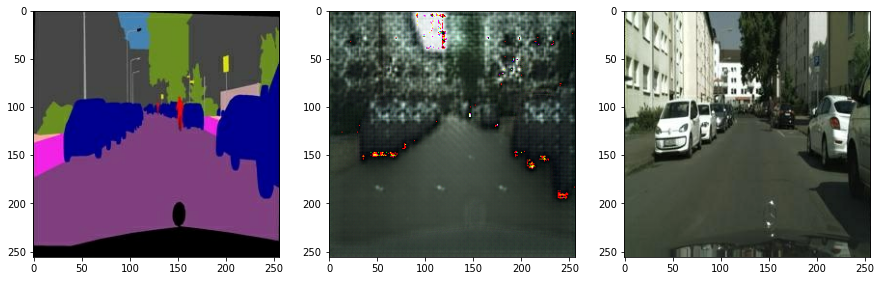

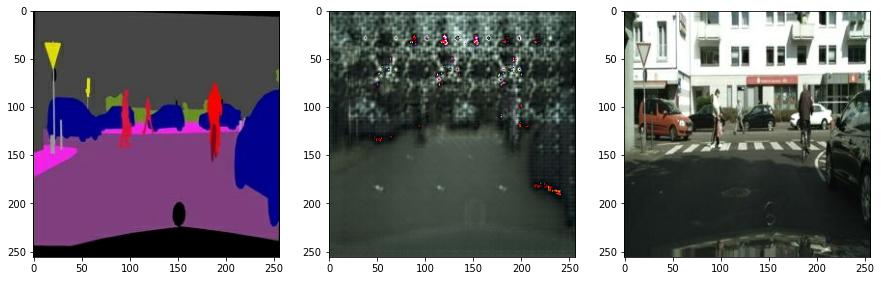

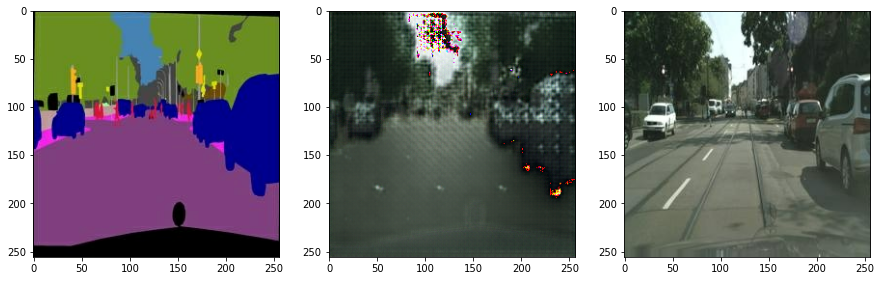

In [27]:
for test_ind in range(0,5):

    f = data_path2 + os.listdir(data_path2)[test_ind]
    print(f)
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 **augmentation 방법을 적용**하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator를 사용**해 주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 **중간 손실 값에 대한 로그**를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


# 프로젝트 평가

| 평가문항 | 상세기준 |
|:---|:---|
| 1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다. | 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다. |
| 2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다. | U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다. |
| 3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다. | 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다. |
